# Recommendation system

## Imports

Для начала импортируем библиотеки, которые понадобятся нам для исследовательского анализа данных и дальнейшего построения рекомендательной системы:

In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder

DATA_DIR = "../data/"
ASSETS_DIR = "assets"
RANDOM_STATE = 42
EXPERIMENT_NAME = "RECSYS_DEV"
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

sns.set_theme()

Для удобства хранения артефактов для логирования, создадим так же папку `assets`, если уже не создана:

In [2]:
try:
    os.mkdir(ASSETS_DIR)
except FileExistsError:
    print(f"Directory '{ASSETS_DIR}' has already been created.")

Directory 'assets' has already been created.


## Mlflow tracking

Теперь запускаем трэкинг Mlflow, чтобы можно было производить логирование артефактов, которые будем получать на различных этапах. 

*NOTE*: Перед запуском следующим двух ячеек сналача необходимо развернуть Mlflow с хранилищем артефактов следующими командами из корневой директории проекта:

```bash
cd recsys
sh run_mlflow_server.sh
```

In [ ]:
# os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
# os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
# os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

# mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
# mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [ ]:
# experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
# if not experiment:
#     experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
# else:
#     experiment_id = experiment.experiment_id

## Loading data

Теперь загрузим данные:

In [3]:
%%time
category_tree = pd.read_csv(DATA_DIR + "category_tree.csv")
events = pd.read_csv(DATA_DIR + "events.csv")
item_props_1 = pd.read_csv(DATA_DIR + "item_properties_part1.csv")
item_props_2 = pd.read_csv(DATA_DIR + "item_properties_part2.csv")

CPU times: user 11 s, sys: 1.32 s, total: 12.3 s
Wall time: 21.9 s


## Exploratory data analysis

Прежде чем переходить непосредственно к созданию системы рекомендаций товаром, необходимо сначала изучить данные, выявить их особенности и некоторые закономерности. 

Рассмотрим каждый датафрейм, созданный на предыдущем этапе, по-отдельности:

* Category tree => `category_tree`
* Events => `events`
* Item properties => `item_props_1`, `item_props_2`

### Category tree

In [4]:
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


Данная таблица представляет собой 2 столбца, где мы имеем определенные категории и родительские категогии, к которым они относятся. Посмотрим, как это выглядит:

In [5]:
category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


На первый вгляд неясно, что к чему относится, но если взять например родительскую категорию 1698:

In [6]:
category_tree.query("parentid == 1698")

,categoryid,parentid
1276,1160,1698.0
1283,110,1698.0
1299,1678,1698.0
1300,1034,1698.0
1328,1582,1698.0
1406,1502,1698.0
1651,760,1698.0


Видим, что к некой большой категории с номером 1698 относятся некоторые категории, к которым в свою очередь относятся товары, которые нам предстоит рекомендовать пользователям.

Проверим уникальные значения в каждой из колонок:

In [7]:
cat_ids_unique = category_tree.categoryid.nunique()
par_ids_unique = category_tree.parentid.nunique()

print("Number of unique categories: {:,}".format(cat_ids_unique))
print("Number of unique parent categories: {:,}".format(par_ids_unique))

Number of unique categories: 1,669
Number of unique parent categories: 362


Итак, в данных есть 362 комплексных групп, к которым относятся некоторые из 1669 категорий, содержащих разные товары.

Посмотрим на пропуски:

In [8]:
category_tree.isnull().sum()

categoryid     0
parentid      25
dtype: int64

Получается, что некоторые категории не имеют более старших групп, то есть возможно, что такие категории и являются группами. Для нагядности выведем такие категории:

In [9]:
category_tree[category_tree.parentid.isnull() == True]

,categoryid,parentid
5,231,NaN
589,791,NaN
861,1490,NaN
939,431,NaN
1111,755,NaN
1142,378,NaN
1208,1579,NaN
1211,1394,NaN
1322,659,NaN
1329,1057,NaN


Можем также посмотреть на самые многочисленные группы (возьмем топ-30):

In [10]:
category_tree \
            .groupby("parentid") \
            .agg({"categoryid": "count"}) \
            .sort_values(by="categoryid", ascending=False) \
            .reset_index() \
            .head(30)

,parentid,categoryid
0,250.0,31
1,1009.0,22
2,362.0,22
3,351.0,19
4,1259.0,18
5,1687.0,17
6,945.0,15
7,312.0,15
8,893.0,13
9,1482.0,13


### Events

Теперь посмотрим на события: действия, которые пользователи делали с товарами:

In [11]:
events.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 244.9 MB


In [12]:
events.sample(10, random_state=RANDOM_STATE)

,timestamp,visitorid,event,itemid,transactionid
486798,1435193216976,50734,view,4442,NaN
1145255,1440996903983,355903,view,269631,NaN
1601366,1431280237515,1066758,view,221329,NaN
843976,1439507864399,1049477,view,23683,NaN
2524686,1437601159324,143239,view,6552,NaN
1114057,1440868598798,762715,view,46130,NaN
2361757,1436909226237,976898,view,82224,NaN
1109279,1440779774908,269679,view,164327,NaN
1786895,1431989552823,599789,view,386382,NaN
2297273,1436682358636,270991,view,369195,NaN


Итак, у нас есть порядка двух миллионов различных действий пользователей с товарами, где каждый такой пользователь отмечен в колонке `visitorid`, который выполнял с товаром в `itemid` действие в колонке `event`. Дополнительно у нас есть временная метка `timestamp` с идентификаторов покупки в `transactionid`.

Например, посмотрим на данные для различных пользователей:

In [13]:
events.query("visitorid == 355903")

,timestamp,visitorid,event,itemid,transactionid
1140018,1440996791626,355903,view,389780,NaN
1145219,1440996740746,355903,view,102903,NaN
1145255,1440996903983,355903,view,269631,NaN
1145262,1440996962079,355903,view,136524,NaN


In [14]:
events.query("visitorid == 599729")

,timestamp,visitorid,event,itemid,transactionid
741075,1439005882692,599729,view,442793,NaN


In [15]:
events.query("visitorid == 50734")

,timestamp,visitorid,event,itemid,transactionid
473003,1435192011355,50734,view,101718,NaN
475456,1435191902774,50734,view,365204,NaN
485288,1435191946820,50734,view,365204,NaN
486752,1435191236400,50734,view,272907,NaN
486798,1435193216976,50734,view,4442,NaN
486857,1435192854825,50734,view,4442,NaN
490545,1435194074910,50734,view,365204,NaN
539163,1435352138722,50734,view,79285,NaN


Взятые три случайных пользователя по нашим данным просто просматривали товары без каких-то дальнейших действий. 

Посмотрим на данные, где все же был зафиксирован факт покупки:

In [16]:
events[~events.transactionid.isna()]

,timestamp,visitorid,event,itemid,transactionid
130,1433222276276,599528,transaction,356475,4000.0
304,1433193500981,121688,transaction,15335,11117.0
418,1433193915008,552148,transaction,81345,5444.0
814,1433176736375,102019,transaction,150318,13556.0
843,1433174518180,189384,transaction,310791,7244.0
...,...,...,...,...,...
2755294,1438377176570,1050575,transaction,31640,8354.0
2755349,1438379878779,861299,transaction,456602,3643.0
2755508,1438357730123,855941,transaction,235771,4385.0
2755603,1438355560300,548772,transaction,29167,13872.0


Только около 22 тысячи действий пользователей из двух миллионов привели к покупке, что отмечено действием `transaction`.

Возьмем трех таких пользователей:

In [17]:
events.query("visitorid == 599528")

,timestamp,visitorid,event,itemid,transactionid
112,1433221941632,599528,addtocart,356475,NaN
130,1433222276276,599528,transaction,356475,4000.0
16729,1433221896102,599528,view,356475,NaN
29505,1433297545235,599528,view,356475,NaN
114163,1433625010602,599528,view,356475,NaN
145498,1433731497480,599528,view,356475,NaN
171995,1433896477794,599528,view,356475,NaN
187497,1433896449376,599528,view,356475,NaN
192471,1433960567121,599528,view,356475,NaN
197272,1433960259198,599528,view,356475,NaN


In [18]:
events.query("visitorid == 1051054")

,timestamp,visitorid,event,itemid,transactionid
2739787,1438359416397,1051054,transaction,463002,11404.0
2739839,1438358858548,1051054,addtocart,312728,NaN
2755578,1438359194127,1051054,addtocart,463002,NaN
2755593,1438358847786,1051054,view,312728,NaN
2755607,1438358989163,1051054,transaction,312728,17579.0


In [19]:
events.query("visitorid == 861299").tail(15)

,timestamp,visitorid,event,itemid,transactionid
2754118,1438365085777,861299,view,204057,NaN
2754591,1438383952746,861299,view,391484,NaN
2754701,1438370210252,861299,view,546,NaN
2754754,1438368794533,861299,view,367032,NaN
2754872,1438370067882,861299,view,546,NaN
2754908,1438390902050,861299,view,295448,NaN
2754994,1438388002882,861299,view,243355,NaN
2755003,1438386491922,861299,view,30308,NaN
2755033,1438389817314,861299,addtocart,191763,NaN
2755156,1438376953339,861299,transaction,22969,14059.0


Видим, что до покупки пользователь добавляет товар в корзину (действие `addtocart`). Из действий случайных трех пользователей видно, что так обычно и происходит, но есть действия, где после добавления товара в корзину ничего не случается дальше.

Расчитаем число уникальных пользователей и товаров:

In [20]:
users_unique = events.visitorid.nunique()
items_unique = events.itemid.nunique()

print("Number of unique users: {:,}".format(users_unique))
print("Number of unique items: {:,}".format(items_unique))

Number of unique users: 1,407,580
Number of unique items: 235,061


Наблюдаем довольно обширное число товаров вместе с почти полутора миллиона пользователей.

Посмотрим, как распределены действия пользователей:

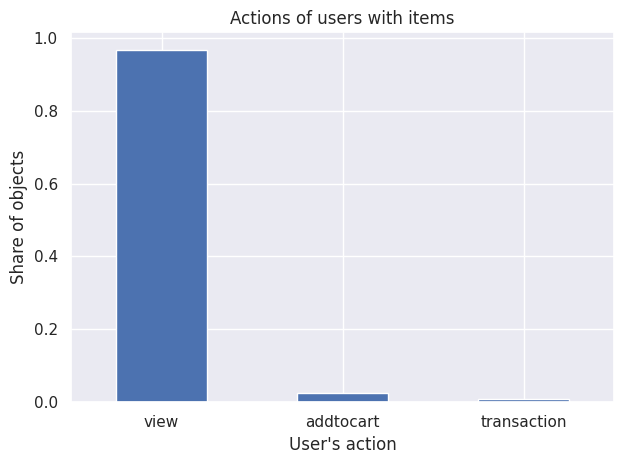

In [21]:
events.event \
    .value_counts(normalize=True) \
    .plot(kind="bar")
plt.xticks(rotation=0)
plt.ylabel("Share of objects")
plt.xlabel("User's action")
plt.title("Actions of users with items")
plt.tight_layout()
plt.savefig(f"{ASSETS_DIR}/user_actions.png")
plt.show()

Видно, что в основном пользователи только смотрят товары, но не все такие действия реализуются в покупку. Даже добавление в корзину (как было замечено выше) не всегда приводит к покупке. Например, пользователь может добавить товар в корзину, чтобы сохранить его на будущее.

Посмотрим на транзакции подробнее:

In [22]:
events_transactions = events[~events.transactionid.isna()]
events_transactions

,timestamp,visitorid,event,itemid,transactionid
130,1433222276276,599528,transaction,356475,4000.0
304,1433193500981,121688,transaction,15335,11117.0
418,1433193915008,552148,transaction,81345,5444.0
814,1433176736375,102019,transaction,150318,13556.0
843,1433174518180,189384,transaction,310791,7244.0
...,...,...,...,...,...
2755294,1438377176570,1050575,transaction,31640,8354.0
2755349,1438379878779,861299,transaction,456602,3643.0
2755508,1438357730123,855941,transaction,235771,4385.0
2755603,1438355560300,548772,transaction,29167,13872.0


In [23]:
events.transactionid.nunique()

17672

In [24]:
events_transactions[
    events_transactions.duplicated(subset=["transactionid"])
].sort_values(by="transactionid")

,timestamp,visitorid,event,itemid,transactionid
1793308,1431978994534,288956,transaction,432742,12.0
77335,1433448499720,527277,transaction,397642,23.0
80335,1433448499642,527277,transaction,93556,23.0
92102,1433448499642,527277,transaction,57548,23.0
2533069,1437584753292,518659,transaction,130226,27.0
...,...,...,...,...,...
805249,1439345589053,530559,transaction,157743,17660.0
791365,1439345588928,530559,transaction,265920,17660.0
929833,1439949233505,795731,transaction,442610,17662.0
924918,1439924299698,465862,transaction,180349,17663.0


Из ячеек выше видно, что число уникальных идентификаторов транзакций не совпадает с общим числом транзакций пользователей. Это результат того, что пользователи могут добавлять в корзину и покупать сразу несколько товаров, то есть у таких пользователей для разных товаров будет один идентификатор транзакции.

Можем также взглянуть на пользователей с большим числом покупок:

In [25]:
events \
    .groupby("visitorid") \
    .agg({"transactionid": "nunique"}) \
    .sort_values(by="transactionid", ascending=False) \
    .reset_index() \
    .head(30)

,visitorid,transactionid
0,1150086,502
1,152963,278
2,530559,221
3,684514,162
4,76757,155
5,861299,148
6,138131,137
7,247235,124
8,1297062,111
9,890980,104


И так же на наиболее покупаемые товары:

In [26]:
events \
    .groupby("itemid") \
    .agg({"transactionid": "nunique"}) \
    .sort_values(by="transactionid", ascending=False) \
    .reset_index() \
    .head(30)

,itemid,transactionid
0,461686,133
1,119736,96
2,213834,92
3,312728,46
4,7943,46
5,445351,45
6,48030,41
7,248455,38
8,420960,38
9,17478,37


### Item properties

У нас остался последний датасет, который поделен на две части - характеристики товаров. Рассмотрим каждый датафрейм:

In [27]:
item_props_1.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 1.5 GB


In [28]:
item_props_2.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275903 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 1.3 GB


Итак, имеется обширная информация о характеристиках товаров, где для каждого товара `itemid` имеется некая обезличенная фича `property` с соответствующими значениями `value`. 

Посмотрим на выборку из датафреймов:

In [29]:
item_props_1.sample(10, random_state=RANDOM_STATE)

,timestamp,itemid,property,value
6816798,1432436400000,311133,640,707081 1182787
4013610,1433646000000,365976,960,769062
938474,1435460400000,424505,159,519769
337195,1436670000000,399089,790,n13068.000
8782494,1440298800000,351533,962,664227 1305534 664227 463202 664227
5911718,1433646000000,155931,888,5135 837239 1019438
3494185,1432436400000,24798,602,663779
5279738,1434250800000,444574,678,259302 398108
9773229,1433041200000,44467,888,586893 911150 155620
8085656,1439694000000,449786,283,598588 1271791 380470 n6222072.000 n24.000 112...


In [30]:
item_props_1.itemid.nunique()

417053

In [31]:
item_props_1.property.value_counts()

property
888           1629817
790            970800
available      817387
categoryid     426305
6              343207
               ...   
471                 1
244                 1
424                 1
494                 1
712                 1
Name: count, Length: 1097, dtype: int64

In [33]:
item_props_2.sample(10, random_state=RANDOM_STATE)

,timestamp,itemid,property,value
2332480,1440298800000,62231,888,1059970
4747909,1431226800000,341153,categoryid,730
6928955,1433041200000,215256,categoryid,1084
3216248,1441508400000,209931,790,n112668.000
7608637,1437274800000,9624,335,769062
4301880,1438484400000,8620,663,1297729 n156.000 606827
142504,1433646000000,145511,790,n39480.000
5069724,1433646000000,242515,839,518500
5643877,1431226800000,298548,6,619728
8778673,1436670000000,441662,663,1297729 n156.000 606827


In [34]:
item_props_2.itemid.nunique()

417053

In [35]:
item_props_2.property.value_counts()

property
888           1370581
790            819716
available      686252
categoryid     361909
6              288264
               ...   
634                 1
57                  1
1091                1
522                 1
769                 1
Name: count, Length: 1094, dtype: int64

Заметим из ячеек выше, что:

1. В значениях характеристик товаров присутствуют значения типа `n156` или `274.200`, с которыми нужно будет отдельно поработать на этапе обработки. 
2. В обоих датафреймах число уникальных товаров одинаково, то есть можем предположить, что разделение на два датасета было вызвано большим объемом данных, то есть каждый датафрейм дополняет другой.
3. Глядя на колонку `property` замечаем, что здесь присутствуют не только закодированные фичи, но и совершенно понятные `available` и `categoryid`, которые дают нам понять, какие товары доступны и к каким категориям относятся.

### Logging artefacts (Mlflow)

In [ ]:
# RUN_NAME = "eda_analysis"
# with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
#     run_id = run.info.run_id

#     mlflow.log_artifact(f"{ASSETS_DIR}/eda_results.md", "eda")
#     mlflow.log_artifact(f"{ASSETS_DIR}/user_actions.png", "eda")

### Conclusion

После детального рассмотрения данных, может подвести следующий итог по первичному анализу данных:

1. Данные, с которыми предстоит работать, включают (*i*) информацию о различных действиях пользователей с товарами, (*ii*) данные о категориях рекомендуемых товаров и группах категорий (родительские категории), а также (*iii*) характеристики товаров.
2. Не все категории товаров могут быть частью более обширной группы: было установлено, что некоторые (а именно 25) категории не имеют родительских категорий и поэтому, скорее всего, не имеют более широкого разделения. 
3. Различные действия пользователей охватывают обычные действия, которые пользователь проводит на сайте: просмотр товара, его добавление в корзину и собственно саму покупку. Причем, как обычно и происходит, наибольшая доля таких действий относятся к просмотру товара. Остальная доля приходится на добавление в корзину и покупки, однако не все действия по добавлению товара в корзину заканчиваются покупкой. 
4. Характеристики товаров представляют собой два датасета с обширной информацией о различных фичах и их значениях. Была выявлена проблема формата значений характеристик, которая могла возникнуть в процессе скрэппинга данных.

## Building recommendations

На данном этапе мы произведем генерацию рекомендаций нескольких видов:

1. Оффлайн рекомендации
    * Персональные рекомендации
    * Топ популярных товаров
2. Онлайн рекомендации (схожесть товаров)

### Preprocessing events

Сначала сделаем дополнительную предобработку событий.

In [39]:
events = events.rename(
    columns={
        "visitorid": "user_id",
        "itemid": "item_id",
        "transactionid": "transaction_id",
    }
)
events.head()

,timestamp,user_id,event,item_id,transaction_id
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [40]:
events = events[events.event != "transaction"]
events.tail()

,timestamp,user_id,event,item_id,transaction_id
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN
2756100,1438400163914,199536,view,152913,NaN


In [41]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2733644 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   timestamp       int64  
 1   user_id         int64  
 2   event           object 
 3   item_id         int64  
 4   transaction_id  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 125.1+ MB


Теперь конвертируем временные метки в колонке `timestamp` в дату. Для этого определим функцию `timestamp2date()`, которая будет это делать, а затем применим ее к соответствующей колонке:

In [51]:
def timestamp2date(timestamp):
    """Converts timestamp into a date."""
    date = datetime.fromtimestamp(timestamp / 1000)
    return date.date()

In [52]:
events["executed_at"] = events["timestamp"].apply(timestamp2date)
events["executed_at"] = pd.to_datetime(events["executed_at"])
events

,timestamp,user_id,event,item_id,transaction_id,executed_at
0,1433221332117,257597,view,355908,NaN,2015-06-02
1,1433224214164,992329,view,248676,NaN,2015-06-02
2,1433221999827,111016,view,318965,NaN,2015-06-02
3,1433221955914,483717,view,253185,NaN,2015-06-02
4,1433221337106,951259,view,367447,NaN,2015-06-02
...,...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN,2015-08-01
2756097,1438399813142,762376,view,115946,NaN,2015-08-01
2756098,1438397820527,1251746,view,78144,NaN,2015-08-01
2756099,1438398530703,1184451,view,283392,NaN,2015-08-01


In [53]:
print("Data start: {}".format(events.executed_at.min()))
print("Data ended: {}".format(events.executed_at.max()))

Data start: 2015-05-03 00:00:00
Data ended: 2015-09-18 00:00:00


Итак теперь более ясно видно, что в нашей выборке данных начало находится 3 мая 2015 года, а кончается 18 сентября того же года.

Посмотрим на число уникальных пользователей и товаров:

In [55]:
users_unique = events.user_id.nunique()
items_unique = events.item_id.nunique()

print("Number of unique users: {:,}".format(users_unique))
print("Number of unique items: {:,}".format(items_unique))

Number of unique users: 1,407,500
Number of unique items: 235,060


Как уже было установлено ранее, среди этих пользователей были следующие действия:

In [56]:
events.event.value_counts()

event
view         2664312
addtocart      69332
Name: count, dtype: int64

Мы не сможем построить рекомендации, если у нас не будет некоторого аналога рейтинга. Воспользуемся в данном случае нормализированной популярностью товара среди пользователей, чья область определения будет от нуля до одного, где максимальной значение будет у самого популярного товара: 

In [57]:
ratings = {
    "view": 0.1,
    "addtocart": 1.0,
}

events["rating"] = events["event"].map(ratings)
events.head()

,timestamp,user_id,event,item_id,transaction_id,executed_at,rating
0,1433221332117,257597,view,355908,NaN,2015-06-02,0.1
1,1433224214164,992329,view,248676,NaN,2015-06-02,0.1
2,1433221999827,111016,view,318965,NaN,2015-06-02,0.1
3,1433221955914,483717,view,253185,NaN,2015-06-02,0.1
4,1433221337106,951259,view,367447,NaN,2015-06-02,0.1


In [58]:
# item_popularity = events.query("event == 'addtocart'").groupby("itemid")["visitorid"].nunique()
# item_popularity /= item_popularity.max()
# item_popularity = item_popularity.reset_index()
# item_popularity = item_popularity.rename(
#     columns={
#         "visitorid": "item_selected"
#     }
# )
# item_popularity.sort_values(by="item_selected", ascending=False)

Добавим рейтинг к нашим событиям:

In [59]:
# events = events.merge(
#     item_popularity,
#     on="itemid",
#     how="left"
# )
# events.head()

In [60]:
# events["item_selected"] = events["item_selected"].fillna(0)
# events.head()

Для удобства дальнейших расчетов, закодируем идентификаторы пользователей и товаров:

In [61]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

In [63]:
user_encoder.fit(events["user_id"])
item_encoder.fit(events["item_id"])

events["user_id_encoded"] = user_encoder.transform(events["user_id"])
events["item_id_encoded"] = item_encoder.transform(events["item_id"])
events.head()

,timestamp,user_id,event,item_id,transaction_id,executed_at,rating,user_id_encoded,item_id_encoded
0,1433221332117,257597,view,355908,NaN,2015-06-02,0.1,257588,179332
1,1433224214164,992329,view,248676,NaN,2015-06-02,0.1,992274,125263
2,1433221999827,111016,view,318965,NaN,2015-06-02,0.1,111011,160652
3,1433221955914,483717,view,253185,NaN,2015-06-02,0.1,483697,127563
4,1433221337106,951259,view,367447,NaN,2015-06-02,0.1,951206,185158


In [64]:
events = events[
    ["user_id", "item_id", "event", 
     "executed_at", "user_id_encoded", 
     "item_id_encoded", "rating"]
]
events.head()

,user_id,item_id,event,executed_at,user_id_encoded,item_id_encoded,rating
0,257597,355908,view,2015-06-02,257588,179332,0.1
1,992329,248676,view,2015-06-02,992274,125263,0.1
2,111016,318965,view,2015-06-02,111011,160652,0.1
3,483717,253185,view,2015-06-02,483697,127563,0.1
4,951259,367447,view,2015-06-02,951206,185158,0.1


### Splitting data

Следующим шагом разделим данные на тренировочную и тестовую выборки. Посмотрим какие даты есть в наших данных из самых последних:

In [14]:
train_test_global_time_split_date = pd.to_datetime("2015-08-01")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx].copy()
events_test = events[~train_test_global_time_split_idx].copy()

print("Train set events number: {:,}".format(events_train.shape[0]))
print("Test set events number: {:,}".format(events_test.shape[0]))

Train set events number: 1,883,573
Test set events number: 850,071


In [15]:
train_events = events_train.event.value_counts()
train_events.name = "train"
test_events = events_test.event.value_counts()
test_events.name = "test"
split_events = pd.concat([
    train_events, 
    test_events
    ], 
    axis=1
).reset_index()
split_events

,event,train,test
0,view,1836747,827565
1,addtocart,46826,22506


In [16]:
users_train = events_train["visitorid"].drop_duplicates().tolist()
users_test = events_test["visitorid"].drop_duplicates().tolist()

common_users = set(users_train) & set(users_test)
cold_users = (set(users_train) | set(users_test)) - set(users_train)

print("Number of unique train users: {:,}".format(len(users_train)))
print("Number of unique test users: {:,}".format(len(users_test)))
print("Number of common users: {:,}".format(len(common_users)))
print("Number of cold users: {:,}".format(len(cold_users)))

Number of unique train users: 962,475
Number of unique test users: 475,290
Number of common users: 30,265
Number of cold users: 445,025


### Generating recommendations

#### Top popular items

In [17]:
top_popular = events_train.query("event == 'addtocart'").itemid \
            .value_counts() \
            .head(100) \
            .reset_index() \
            .rename(columns={
                "count": "items_selected"
            })
top_popular["itemid_encoded"] = item_encoder.transform(top_popular["itemid"])
top_popular

,itemid,items_selected,itemid_encoded
0,461686,162,232496
1,409804,126,206467
2,312728,124,157492
3,29196,116,14707
4,48030,83,24339
...,...,...,...
95,387373,22,195172
96,309821,22,156041
97,354233,22,178513
98,104116,22,52612


In [64]:
top_popular.to_parquet("../data/top_popular.parquet")

#### Personal recommendations

In [17]:
user_item_matrix_train = scipy.sparse.csr_matrix(
    (
    events_train["item_selected"],
    (events_train["visitorid_encoded"], events_train["itemid_encoded"])
    ),
    dtype=np.int8
)
user_item_matrix_train

<1407500x235060 sparse matrix of type '<class 'numpy.int8'>'
	with 1472326 stored elements in Compressed Sparse Row format>

In [18]:
als_params = {
    "factors": 50,
    "iterations": 50,
    "regularization": 0.08,
    "random_state": RANDOM_STATE,
}

als_model = AlternatingLeastSquares(**als_params)
als_model.fit(user_item_matrix_train)

/home/mle-user/mle_projects/final_projects/mle-pr-final/.venv_test/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
%%time
# Retrieving all encoded user identifiers
user_ids_encoded = range(len(user_encoder.classes_))

# Getting recommendations for all users
als_recommendations = als_model.recommend(
    userid=user_ids_encoded, 
    user_items=user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, 
    N=10,
)

CPU times: user 32min 18s, sys: 16min 47s, total: 49min 5s
Wall time: 12min 18s


In [20]:
# Separating identifiers and ALS-scores
track_ids_encoded = als_recommendations[0]
als_scores = als_recommendations[1]

# Building a DataFrame of recommendations
als_recommendations = pd.DataFrame({
    "visitorid_encoded": user_ids_encoded,
    "itemid_encoded": track_ids_encoded.tolist(), 
    "score": als_scores.tolist(),
})
als_recommendations = als_recommendations.explode(["itemid_encoded", "score"], ignore_index=True)

# Types conversions
als_recommendations["itemid_encoded"] = als_recommendations["itemid_encoded"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# Retrieving the original identifiers
als_recommendations["visitorid"] = user_encoder.inverse_transform(als_recommendations["visitorid_encoded"])
als_recommendations["itemid"] = item_encoder.inverse_transform(als_recommendations["itemid_encoded"])
als_recommendations = als_recommendations.drop(columns=["visitorid_encoded", "itemid_encoded"])

# Rearranging columns
als_recommendations = als_recommendations[["visitorid", "itemid", "score"]]

In [21]:
als_recommendations

,visitorid,itemid,score
0,0,24,0.000000e+00
1,0,22,0.000000e+00
2,0,19,0.000000e+00
3,0,17,0.000000e+00
4,0,16,0.000000e+00
...,...,...,...
14074995,1407579,218794,5.039551e-13
14074996,1407579,339703,4.979730e-13
14074997,1407579,46156,4.901656e-13
14074998,1407579,344071,4.545399e-13


In [100]:
als_recommendations = als_recommendations.query("score != 0")
als_recommendations

,visitorid,itemid,score
30,7,221329,0.016787
31,7,373842,0.016762
32,7,436549,0.013918
33,7,289915,0.013040
34,7,456975,0.011085
...,...,...,...
3115085,1407578,380993,0.001620
3115086,1407578,138427,0.001384
3115087,1407578,98095,0.001349
3115088,1407578,331725,0.001315


In [76]:
als_recommendations.to_parquet(DATA_DIR + "personal_recommendations.parquet")

#### Similar items

In [78]:
%%time
train_item_ids_encoded = range(len(item_encoder.classes_))

similar_items = als_model.similar_items(train_item_ids_encoded, N=5)

CPU times: user 6min 22s, sys: 4min 42s, total: 11min 4s
Wall time: 2min 47s


In [79]:
# Separating identifiers from similarity scores
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

# Building a DataFrame of track similarities
similar_items = pd.DataFrame({
    "itemid_encoded": train_item_ids_encoded,
    "sim_itemid_encoded": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})
similar_items = similar_items.explode(["sim_itemid_encoded", "score"], ignore_index=True)

# Converting types
similar_items["sim_itemid_encoded"] = similar_items["sim_itemid_encoded"].astype("int64")
similar_items["score"] = similar_items["score"].astype("float")

# Retrieving original track identifiers
similar_items["itemid_1"] = item_encoder.inverse_transform(similar_items["itemid_encoded"])
similar_items["itemid_2"] = item_encoder.inverse_transform(similar_items["sim_itemid_encoded"])
similar_items = similar_items.drop(columns=["itemid_encoded", "sim_itemid_encoded"])

# Filtering out tracks similar to themselves
similar_items = similar_items.query("itemid_1 != itemid_2")

similar_items = similar_items[["itemid_1", "itemid_2", "score"]]
similar_items

,itemid_1,itemid_2,score
0,3,15,0.000000
1,3,9,0.000000
2,3,6,0.000000
3,3,4,0.000000
6,4,378747,0.645888
...,...,...,...
1175299,466864,310413,0.601719
1175301,466867,10305,0.649785
1175302,466867,81139,0.623295
1175303,466867,286051,0.620849


In [82]:
similar_items = similar_items.query("score != 0")

In [83]:
similar_items.to_parquet(DATA_DIR + "similar.parquet")

### Logging artifacts (Mlflow)

In [65]:
# class ALSModel(mlflow.pyfunc.PythonModel):

#     def __init__(self, model):
#         super().__init__()
#         self._model = model
    
#     def predict(self, context, model_input):
        
        
#         return recs

In [ ]:
# als_model_mlflow = ALSModel(model=als_model)

In [ ]:
# with mlflow.start_run(run_name="generating_recs", experiment_id=EXPERIMENT_NAME) as run:
#     run_id = run.info.run_id
    
#     mlflow.log_params(als_params)

#     model_info = mlflow.pyfunc.log_model(
#         python_model=als_model_mlflow, artifact_path='als'
#     )

## Building ranking model

In [84]:
test_events

event
view           827565
addtocart       22506
transaction      7001
Name: test, dtype: int64

In [22]:
split_date_for_labels = pd.to_datetime("2015-09-01")

split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

print(events_labels.shape, events_test_2.shape)

(548730, 7) (301341, 7)


In [32]:
events_labels.event.value_counts()

event
view         533905
addtocart     14825
Name: count, dtype: int64

In [24]:
events_test_2.event.value_counts()

event
view         293660
addtocart      7681
Name: count, dtype: int64

In [25]:
events_labels["target"] = 0
events_labels.loc[(events_labels["event"] == 'addtocart'), "target"] = 1

In [26]:
events_labels.target.value_counts()

target
0    533905
1     14825
Name: count, dtype: int64

In [27]:
# Adding target to the recommendations
candidates = als_recommendations.merge(
    events_labels[["visitorid", "itemid", "target"]],
    on=["visitorid", "itemid"],
    how="left",
)

# Replacing NaNs with zero (negative class)
candidates["target"] = candidates["target"].fillna(0).astype("int")

In [28]:
candidates.target.value_counts()

target
0    14075247
1          51
Name: count, dtype: int64

In [30]:
candidates_for_train = pd.concat([
    candidates.query("target == 1"),
    candidates.query("target == 0") \
        .groupby("visitorid") \
        .apply(lambda x: x.sample(5, random_state=RANDOM_STATE))
])

KeyboardInterrupt: 

In [106]:
candidates_for_train = candidates.reset_index(drop=True)
display(candidates_for_train.head())
display(candidates_for_train.info())

,visitorid,itemid,score,target
0,7,221329,0.016787,0
1,7,373842,0.016762,0
2,7,436549,0.013918,0
3,7,289915,0.013040,0
4,7,456975,0.011085,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2135628 entries, 0 to 2135627
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   visitorid  int64  
 1   itemid     int64  
 2   score      float64
 3   target     int64  
dtypes: float64(1), int64(3)
memory usage: 65.2 MB


None

In [45]:
from catboost import CatBoostClassifier, Pool

In [46]:
# Specifying features and target
features = ["score"]
target = ["target"]

# Pooling training data
train_data = Pool(
    data=candidates_for_train[features],
    label=candidates_for_train[target],
)

# Specifying model parameters
catboost_params = {
    "iterations": 100,
    "learning_rate": 0.09,
    "depth": 3,
    "verbose": 100,
    "loss_function": "Logloss",
    "auto_class_weights": "Balanced",
    "random_seed": RANDOM_STATE,
}
model = CatBoostClassifier(**catboost_params)

# Launching training
model.fit(train_data)

0:	learn: 0.6188256	total: 2.14s	remaining: 1h 29s


KeyboardInterrupt: 